# **Seminário Inteligência Artificial MESC - 2024-T4**
#
## Rafael Medeiros e Orlando Ferreira Jr.
## Ferramenta: Facebook Prophet
##
### **Tarefas**
* Investigar dados faltantes
* Investigar outliers
* Identificar tendências
* Identificar sazonalidades
* Identificar autocorrelação
### **Métricas de avaliação**
* MAPE
* MSE
* RMSE

In [30]:
# Carregando bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [31]:
# Carregando BD
df = pd.read_csv("../data/water_quality.csv")

In [32]:
### Informações Básicas do Dataset ###

# Dimensões do dataset
print("Verificando o formato do dataset:\n", df.shape)

# Visualizar as primeiras linhas
print("\nVerificando as primeiras linhas do dataset:\n", df.head())

# Verificar os tipos de dados e valores nulos
print("\nVerificando as principais informações do dataset:\n", df.info())

# Resumo estatístico de colunas numéricas
print("\nVerificando o resumo das estatísticas quantitativas do dataset:\n",df.describe())

# Verificar a lista de colunas
print("\nVerificando as colunas do dataset:\n", df.columns)

Verificando o formato do dataset:
 (2373, 15)

Verificando as primeiras linhas do dataset:
          Data  Turbidity        pH  Alkalinity  DissolvedOxygen  \
0  2018-01-01   7.367186  6.845486   25.788530         6.715897   
1  2018-01-02  35.755183  6.807069   19.943425         5.233228   
2  2018-01-03   9.341618  6.906234   19.910010         5.856647   
3  2018-01-04  16.105204  6.817615   20.249162         6.004393   
4  2018-01-05  16.531502  7.045985   18.217803         6.050563   

   RainAccumulation1D  RainAccumulation2D  RainAccumulation3D  \
0            0.001155            2.794847            2.318741   
1            0.001092            0.255247            0.718060   
2            0.012032            0.013785            0.029363   
3            0.002139            1.929273            0.788018   
4            0.002479            1.077661            0.135524   

   RainAccumulation4D  RainAccumulation5D  RainAccumulation6D  \
0            1.460683            9.169686        

In [33]:
# ajustando o tipo de dados

df["Data"] = pd.to_datetime(df["Data"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data                 2373 non-null   datetime64[ns]
 1   Turbidity            2373 non-null   float64       
 2   pH                   2373 non-null   float64       
 3   Alkalinity           2373 non-null   float64       
 4   DissolvedOxygen      2373 non-null   float64       
 5   RainAccumulation1D   2373 non-null   float64       
 6   RainAccumulation2D   2373 non-null   float64       
 7   RainAccumulation3D   2373 non-null   float64       
 8   RainAccumulation4D   2373 non-null   float64       
 9   RainAccumulation5D   2373 non-null   float64       
 10  RainAccumulation6D   2373 non-null   float64       
 11  RainAccumulation7D   2373 non-null   float64       
 12  RainAccumulation15D  2373 non-null   float64       
 13  RainAccumulation30D  2373 non-nul

In [34]:
# Criar uma cópia para verificar descontinuidades
df_copy = df.copy()
df_copy["diff_days"] = df_copy["Data"].diff().dt.days  # Diferença entre datas em dias
descontinuidades = df_copy[df_copy["diff_days"] > 1]  # Identificar onde há gaps

# Verificar se há descontinuidade e exibir o resultado
if not descontinuidades.empty:
    print("Há descontinuidades na série temporal. Detalhes:")
    print(discontinuities[["data", "diff_days"]])  # Exibir apenas colunas relevantes
else:
    print("Não há descontinuidades na série temporal.")

Não há descontinuidades na série temporal.


## Embasamento matemático do FB Prophet
O modelo matemático do FB Prophet é representado pela equação abaixo

**y(t) = g(t) + s(t) + h(t) + $\epsilon_t$**

onde:
* **g(t)** é o componente de crescimento, ou a tendência geral, que não é periódica
* **s(t)** é o componente de sazonalidade, a somatória de todos os componentes periódicos
* **h(t)** é o componene de feriado, representando todos os eventos especiais
* **$\epsilon_t$** é a componente de erro



### Componente de crescimento linear
**g(t) = (k + $\alpha(t)^T\delta$)t + (m + $\alpha(t)^T\gamma$)**
onde:
* **k** é a taxa de crescimento, a inclinação da reta
* **$\alpha(t)$** é o vetor que indica a localização das mudanças na inclinação da reta
* **$\delta$** é o vetor de ajuste da inclinação da reta
* **m** parâmetro de offset
* **$\gamma$** é o vetor de ajuste do offset

A equação acima tem similaridades com a equação da reta **y = mx + b**. 

A grande diferença está no componente **(k + $\alpha(t)^T\delta$)** indicando que a inclinação da reta é uma função de **t**.

Devido à essa propriedade, inclinação da reta **k** está em conjunto com o termo  **$\alpha(t)^T\delta$**.

O **$\delta$** é o vetor de ajuste da taxa da inclinação da reta, onde **$\delta_j$** é a mudança na inclinação ocorrida o tempo **$s_j$**.

O vetor **$\alpha(t)$** indica a localização das mudanças, conforme abaixo:

$a_j(t) = \begin{cases} 
1, & \text{se } t \geq s_j \\
0, & \text{para todos outros casos}
\end{cases}$

Ou seja, a inclinação é constante, mas permite que ajustes ocorram.

Já o segundo componete da equação, **(m + $\alpha(t)^T\gamma$)**, ajusta a reta com um offset adequado para que não haja descontinuidade quando ocorrer uma mudança de inclinação. 

### Componente de crescimento logístico
Para problema de regressão logística, a seguinte equação é utilizada:

$g(t) = \frac{C}{1 + \exp(-k(t - m))}$

onde:
* C é assíntota da curva logística, que também pode variar com o tempo, conforme a configuração do Prophet.

Permitindo se sejam feitos os mesmos ajustes na equação da regressão linear, que foram realizados na inclinação e offset, a regressão logística fica dessa forma:

$g(t) = \frac{C}{1 + \exp(-(k + \alpha(t)^T\delta)(t - (m + \alpha(t)^T\gamma)))}$

### Sazonalidade
Para sazonalidade, o Prophet usa a modelagem através de séries de Fourier. A modelagem é feita da seguinte forma:

$$
s(t) = \sum_{n=1}^N \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)
$$


### Feriados
É possível ajustar o Prophet com eventos especiais para prover maior robustez de previsibilidade ao modelo.

O Prophet estima os desvios na tendência e sazonalidade pelas datas passadas e aplica as mesmas mudanças a data futuras.

A modelagem é feita por meio da equação:

$$
h(t) = Z(t)k
$$

onde
$$
Z(t) = [1(t \in D_1), ..., 1(t \in D_L)]
$$
é uma matriz de regressores com os dados sobre os feriados e $k$ é um vetor com as mudanças nas previsõe relativas aos feriados. 


In [36]:
# dividindo em dataframes menores para cada atributo
# a nomenclatura das variáveis segue o padrão:
# df_column

for column in df.columns[1:]:  # Ignorar a primeira coluna ("data")
    globals()[f"df_{column}"] = df[["Data", column]]

In [37]:
# testando as funcionalidades do Prophet com o atributo "Alkalinity"

df_Alkalinity.columns = ['ds', 'y']

df_Alkalinity.head()

,ds,y
0,2018-01-01,25.788530
1,2018-01-02,19.943425
2,2018-01-03,19.910010
3,2018-01-04,20.249162
4,2018-01-05,18.217803


11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing


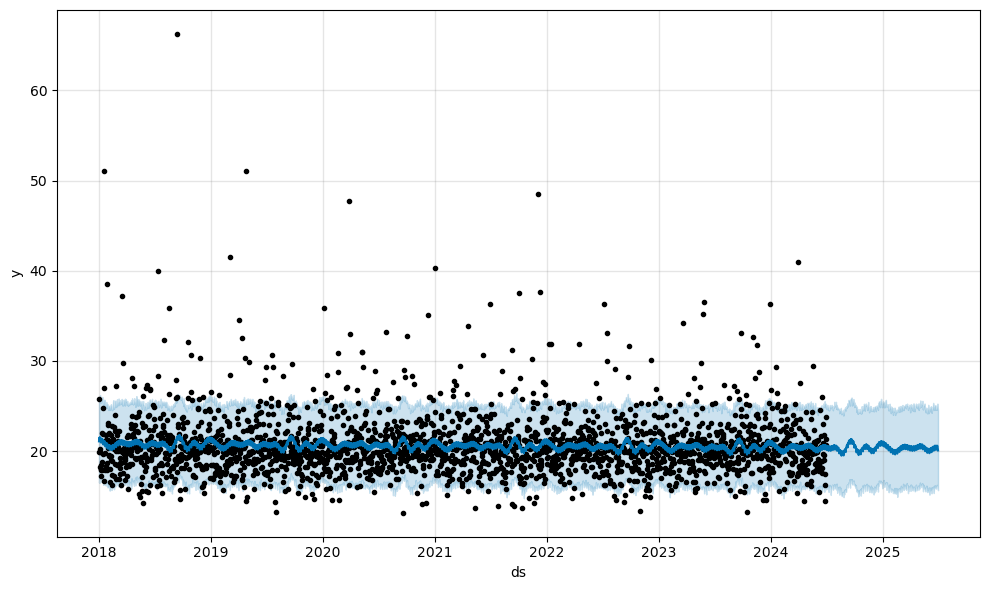

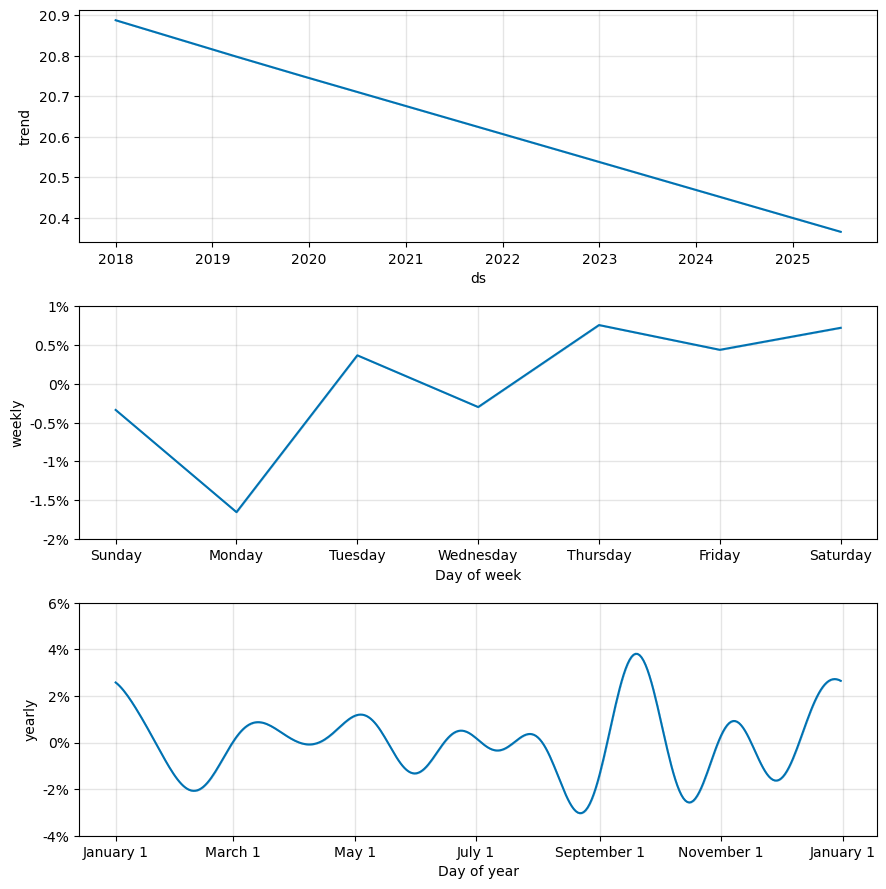

In [38]:
# testando o gráfico de predição

model = Prophet(seasonality_mode='multiplicative')
model.fit(df_Alkalinity)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()
fig2 = model.plot_components(forecast)
plt.show()